# Proyek Klasifikasi Gambar: Penyakit Daun Padi
- **Nama:** Aprizal
- **Email:** aprizalkingevil111@gaiil.com
- **ID Dicoding:** rizal_777

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UbM7T9lC2C3agZwpSyee")
project = rf.workspace("proyek-asah").project("deteksi-penyakit-daun-padi-3e5p1-0k9ae")
version = project.version(1)
dataset = version.download("folder", location="/content/penyakit-padi")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/penyakit-padi in folder:: 100%|██████████| 11691/11691 [00:05<00:00, 2243.48it/s]


### Menggabungkan folder train, test, valid menjadi satu folder baru

In [ ]:
# Folder Utama
DATASET_ROOT = 'penyakit-padi'

# Daftar folder yang akan digabungkan: train, test, valid
SOURCE_FOLDERS = ['train', 'test', 'valid']

# Nama folder tujuan untuk menyimpan semua data yang digabungkan
TARGET_ROOT = os.path.join(DATASET_ROOT, '/content/penyakit-padi-all')

print(f"Menggabungkan data dari {SOURCE_FOLDERS} ke dalam folder: {TARGET_ROOT}")
print("-" * 50)

# 1. Buat folder tujuan utama jika belum ada
if not os.path.exists(TARGET_ROOT):
    os.makedirs(TARGET_ROOT)
    print(f"Folder tujuan utama '{TARGET_ROOT}' berhasil dibuat.")
else:
    print(f"Folder tujuan utama '{TARGET_ROOT}' sudah ada.")

total_files_copied = 0

# 2. Iterasi melalui setiap folder sumber (train, test, valid)
for split_name in SOURCE_FOLDERS:
    split_path = os.path.join(DATASET_ROOT, split_name)

    # Periksa apakah folder sumber ada
    if not os.path.exists(split_path):
        print(f"Folder sumber '{split_path}' TIDAK DITEMUKAN. Melanjutkan...")
        continue

    print(f"\nMemproses folder: {split_path}")

    # 3. Iterasi melalui semua sub-folder (yaitu, folder kelas)
    for class_name in os.listdir(split_path):
        source_class_path = os.path.join(split_path, class_name)

        # Pastikan item yang ditemukan adalah direktori (folder kelas)
        if os.path.isdir(source_class_path):

            # Tentukan path folder kelas di folder tujuan (misal: all_data/Bacterial Leaf Blight)
            target_class_path = os.path.join(TARGET_ROOT, class_name)

            # Buat folder kelas di folder tujuan jika belum ada
            if not os.path.exists(target_class_path):
                os.makedirs(target_class_path)

            # Iterasi melalui semua file (gambar) di dalam folder kelas sumber
            for filename in os.listdir(source_class_path):
                source_file = os.path.join(source_class_path, filename)
                target_file = os.path.join(target_class_path, filename)

                # Hanya salin jika itu adalah file
                if os.path.isfile(source_file):
                    # Salin file ke folder kelas di folder tujuan
                    # copy2 juga menyalin metadata file
                    shutil.copy2(source_file, target_file)
                    total_files_copied += 1

            print(f"-> Selesai menyalin {class_name} dari '{split_name}'.")

print(f"PROSES PENGGABUNGAN SELESAI!")
print(f"Total file (gambar) yang disalin: {total_files_copied}")
print(f"Semua file sekarang ada di '{TARGET_ROOT}', dengan struktur kelas yang dipertahankan.")

# Tampilkan beberapa folder kelas di hasil gabungan (untuk verifikasi)
print(f"\nFolder Kelas yang ada di '{TARGET_ROOT}':")
try:
    # Filter hanya direktori (folder kelas)
    class_folders = [d for d in os.listdir(TARGET_ROOT) if os.path.isdir(os.path.join(TARGET_ROOT, d))]
    print(class_folders)
except FileNotFoundError:
    print("Folder tujuan tidak ditemukan.")

Menggabungkan data dari ['train', 'test', 'valid'] ke dalam folder: /content/penyakit-padi-all
--------------------------------------------------
Folder tujuan utama '/content/penyakit-padi-all' berhasil dibuat.

Memproses folder: penyakit-padi/train
-> Selesai menyalin Bacterial Leaf Blight dari 'train'.
-> Selesai menyalin Healthy Rice Leaf dari 'train'.
-> Selesai menyalin Neck_Blast dari 'train'.
-> Selesai menyalin Rice Hispa dari 'train'.
-> Selesai menyalin Brown Spot dari 'train'.
-> Selesai menyalin Leaf scald dari 'train'.
-> Selesai menyalin Leaf Blast dari 'train'.
-> Selesai menyalin Sheath Blight dari 'train'.
-> Selesai menyalin Narrow Brown Leaf Spot dari 'train'.

Memproses folder: penyakit-padi/test
-> Selesai menyalin Bacterial Leaf Blight dari 'test'.
-> Selesai menyalin Healthy Rice Leaf dari 'test'.
-> Selesai menyalin Neck_Blast dari 'test'.
-> Selesai menyalin Rice Hispa dari 'test'.
-> Selesai menyalin Brown Spot dari 'test'.
-> Selesai menyalin Leaf scald dari

Jumlah gambar per kelas:
Bacterial Leaf Blight: 1197
Brown Spot     : 1537
Healthy Rice Leaf: 1082
Leaf Blast     : 1713
Leaf scald     : 1332
Narrow Brown Leaf Spot: 954
Neck_Blast     : 1000
Rice Hispa     : 1299
Sheath Blight  : 1545

Total gambar dalam dataset: 11659
Range per kelas: min=954, max=1713


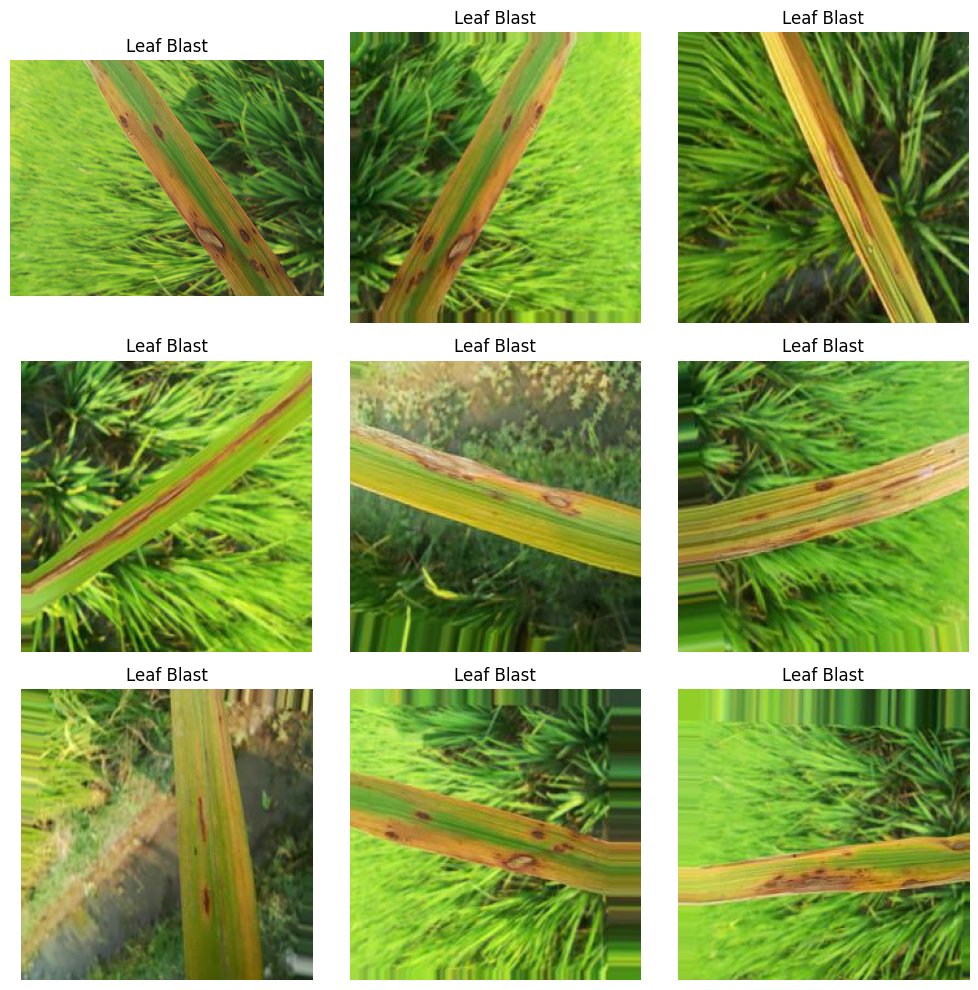

In [ ]:
# Verifikasi struktur & lihat sample
DATASET_PATH = "/content/penyakit-padi-all"   # sesuaikan path
assert os.path.exists(DATASET_PATH), "Path dataset gak ketemu. Sesuaikan dataset."

# Hitung jumlah gambar di setiap folder (per kelas)
image_count_per_class = {}
for class_name in sorted(os.listdir(DATASET_PATH)):
  class_path = os.path.join(DATASET_PATH, class_name)
  if os.path.isdir(class_path):
    image_files = [
        file_name for file_name in os.listdir(class_path)
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    image_count_per_class[class_name] = len(image_files)

# Tampilkan jumlah gambar per kelas
print("Jumlah gambar per kelas:")
for class_name, count in sorted(image_count_per_class.items()):
  print(f"{class_name:<15}: {count}")


# Total & range jumlah gambar

total_images = sum(image_count_per_class.values());
print(f"\nTotal gambar dalam dataset: {total_images}")
print(f"Range per kelas: min={min(image_count_per_class.values())}, max={max(image_count_per_class.values())}")


# Tampilkan contoh dari kelas yang paling banyak datanya
most_common_class = max(image_count_per_class, key=image_count_per_class.get)
sample_images = random.sample(
    [
        file_name for file_name in os.listdir(os.path.join(DATASET_PATH, most_common_class))
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png'))
    ],
    k=min(9, image_count_per_class[most_common_class])
)

plt.figure(figsize=(10, 10))
for index, image_name in enumerate(sample_images):
  image_path = os.path.join(DATASET_PATH, most_common_class, image_name)
  image = Image.open(image_path).convert('RGB')
  plt.subplot(3, 3, index + 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(most_common_class)
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [ ]:
# Path utama dataset
DATASET_PATH = "/content//penyakit-padi-all"

# Path baru untuk hasil split
BASE_PATH = "/content//penyakit-padi-all_split"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALIDATION_PATH = os.path.join(BASE_PATH, 'validation')
TEST_PATH = os.path.join(BASE_PATH, "test")

if os.path.exists(BASE_PATH):
  shutil.rmtree(BASE_PATH)
os.makedirs(TRAIN_PATH)
os.makedirs(VALIDATION_PATH)
os.makedirs(TEST_PATH)


# Split manual folder per kelas
for class_name in os.listdir(DATASET_PATH):
  class_folder = os.path.join(DATASET_PATH, class_name)
  if not os.path.isdir(class_folder):
    continue
  images = [
      os.path.join(class_folder, file)
      for file in os.listdir(class_folder)
      if file.lower().endswith(('.jpg', '.jpeg', '.png'))
  ]

  # Split 70:20:10
  train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
  validation_files, test_files = train_test_split(temp_files, test_size=1/3, random_state=42)

  # Buat folder per kelas di masing-masing split
  for split_name, file_list in zip(
      ["train", "validation", "test"], [train_files, validation_files, test_files]
  ):
    split_class_dir = os.path.join(BASE_PATH, split_name, class_name)
    os.makedirs(split_class_dir, exist_ok=True)
    for file_path in file_list:
      shutil.copy(file_path, split_class_dir)

print("Dataset berhasil dibagi menjadi Train: 70%, Validation: 20%, Test: 10%.")

Dataset berhasil dibagi menjadi Train: 70%, Validation: 20%, Test: 10%.


# Augmentasi

In [ ]:
# Disini yang diaugmentasi hanya train dataset
# Buat objek ImageDataGenerator yang menormalkan gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

validation_generator = val_test_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("\nKelas terdeteksi:")
print(train_generator.class_indices)

Found 8157 images belonging to 9 classes.
Found 2332 images belonging to 9 classes.
Found 1170 images belonging to 9 classes.

Kelas terdeteksi:
{'Bacterial Leaf Blight': 0, 'Brown Spot': 1, 'Healthy Rice Leaf': 2, 'Leaf Blast': 3, 'Leaf scald': 4, 'Narrow Brown Leaf Spot': 5, 'Neck_Blast': 6, 'Rice Hispa': 7, 'Sheath Blight': 8}


## Modelling

In [ ]:
# Menggunakan  Transfer Learning - MobileNet
mobilenet_base = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# hanya pakai knowledge dari ImageNet
for layer in mobilenet_base.layers:
  layer.trainable = False

# verifikasi freezing
num_layers = len(mobilenet_base.layers)
trainable_count = sum(1 for layer in mobilenet_base.layers if layer.trainable)
print(f"Total MobileNet layers: {num_layers}")
print(f"Trainable MobileNet layers: {trainable_count}  (harus 0)")

# tampilkan 10 layer pertama statusnya
for i, layer in enumerate(mobilenet_base.layers[:10]):
    print(f"{i:03d} | {layer.name:30s} | trainable={layer.trainable}")

# Menyiapan model
model = Sequential([
    mobilenet_base,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax') # output sesuai jumlah kelas
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total MobileNet layers: 86
Trainable MobileNet layers: 0  (harus 0)
000 | input_layer                    | trainable=False
001 | conv1                          | trainable=False
002 | conv1_bn                       | trainable=False
003 | conv1_relu                     | trainable=False
004 | conv_dw_1                      | trainable=False
005 | conv_dw_1_bn                   | trainable=False
006 | conv_dw_1_relu                 | trainable=False
007 | conv_pw_1                      | trainable=False
008 | conv_pw_1_bn                   | trainable=False
009 | conv_pw_1_relu                 | trainable=False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,928,713 (14.99 MB)

 Trainable params: 699,465 (2.67 MB)

 Non-trainable params: 3,229,248 (12.32 MB)

In [ ]:
# Create models directory
os.makedirs("models", exist_ok=True)

# Gunakan format Keras
checkpoint_path = "models/best_model.keras"


# Menerakan Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Latih Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)

model.save("models/final_model.keras")

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9157 - loss: 0.2571
Epoch 1: val_accuracy improved from -inf to 0.93782, saving model to models/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9157 - loss: 0.2571 - val_accuracy: 0.9378 - val_loss: 0.1825 - learning_rate: 1.0000e-04
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9142 - loss: 0.2456
Epoch 2: val_accuracy improved from 0.93782 to 0.94511, saving model to models/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9142 - loss: 0.2457 - val_accuracy: 0.9451 - val_loss: 0.1569 - learning_rate: 1.0000e-04
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.2553
Epoch 3: val_accuracy improved from 0.94511 to 0.94726, saving model to models/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9127 - loss: 0.2552 - val_accuracy: 0.9473 - val_loss: 0.1532 - learning_rate: 1.0000e-04
Epoch 4/20
255/255 ━━━

## Evaluasi dan Visualisasi

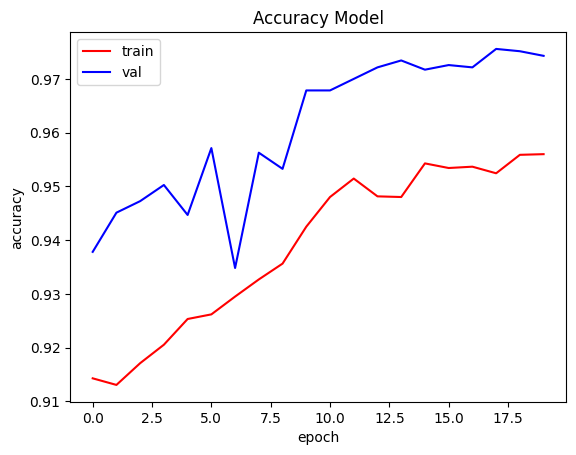

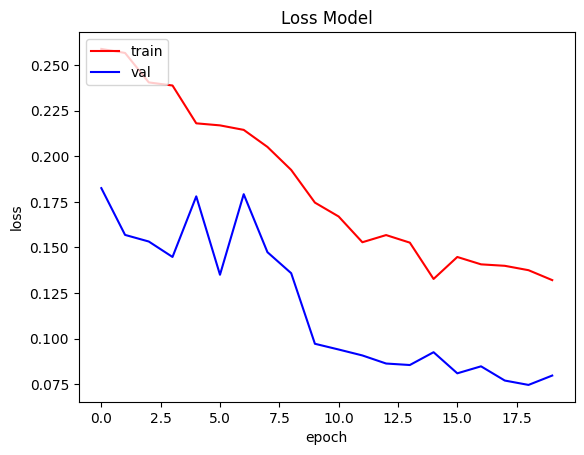

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Loss Model')
plt.show()

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9676 - loss: 0.1048

 AKurasi Test Set: 0.9744
Test Loss: 0.0776
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


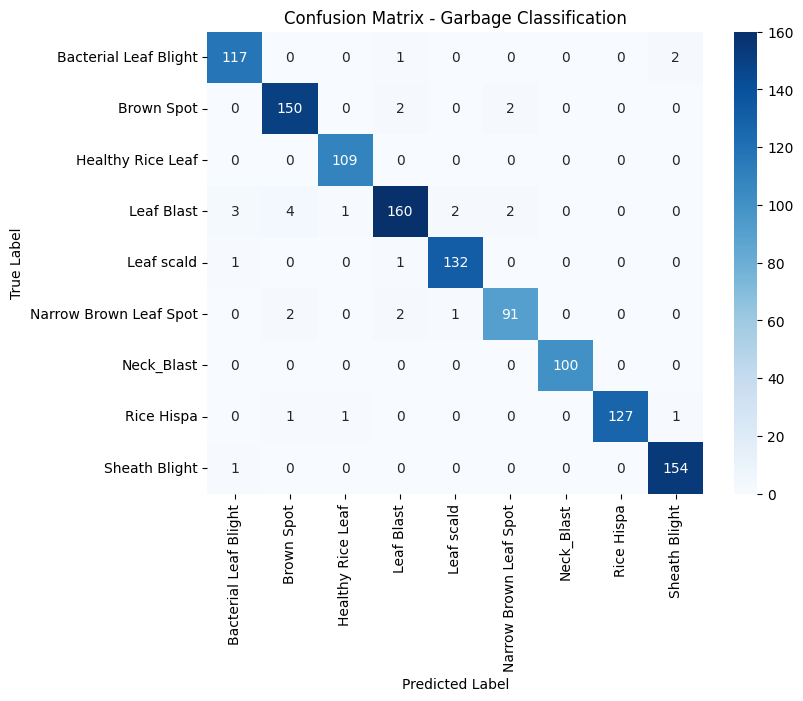


 Classification Report;
                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.96      0.97      0.97       120
            Brown Spot       0.96      0.97      0.96       154
     Healthy Rice Leaf       0.98      1.00      0.99       109
            Leaf Blast       0.96      0.93      0.95       172
            Leaf scald       0.98      0.99      0.98       134
Narrow Brown Leaf Spot       0.96      0.95      0.95        96
            Neck_Blast       1.00      1.00      1.00       100
            Rice Hispa       1.00      0.98      0.99       130
         Sheath Blight       0.98      0.99      0.99       155

              accuracy                           0.97      1170
             macro avg       0.98      0.98      0.98      1170
          weighted avg       0.97      0.97      0.97      1170



In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\n AKurasi Test Set: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

print(f"\n Classification Report;")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

## Konversi Model

In [ ]:
!pip install tensorflowjs
import tensorflowjs as tfjs

# Memuat model terbaik yang telah disimpan sebelumnya
model = tf.keras.models.load_model('models/best_model.keras')

# Direktori untuk menyimpan model TFJS
tfjs_model_dir = 'tfjs_model'

# Konversi dan simpan model ke format TFJS
tfjs.converters.save_keras_model(model, tfjs_model_dir)

print(f"Model berhasil dikonversi dan disimpan ke: {tfjs_model_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi dan disimpan ke: tfjs_model


## Inference (Optional)

In [ ]:
from tensorflow.keras.preprocessing import image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Load the best model
model = tf.keras.models.load_model('models/best_model.keras')

# Get class labels from the train_generator
class_labels = list(train_generator.class_indices.keys())
print(f"Model berhasil dimuat. Label kelas: {class_labels}")

Model berhasil dimuat. Label kelas: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight']


In [ ]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Tambahkan dimensi batch
    img_array = img_array / 255.0  # Rescale seperti saat pelatihan
    return img_array


Mengunggah gambar dari penyimpanan eksternal...


<IPython.core.display.Javascript object>

Gambar terunggah: uploaded_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


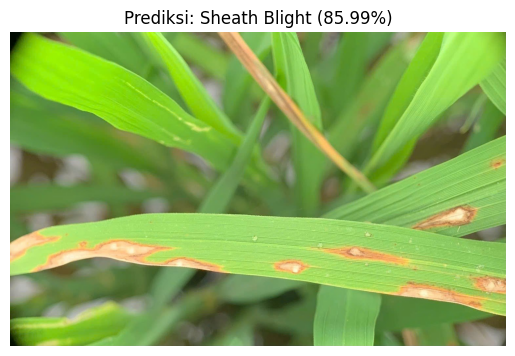

In [ ]:
def upload_photo():
    js = Javascript('''
        async function uploadPhoto() {
            const fileInput = document.createElement('input');
            fileInput.type = 'file';
            fileInput.accept = 'image/*';
            document.body.appendChild(fileInput);
            fileInput.click();

            return new Promise(resolve => {
                fileInput.onchange = () => {
                    const file = fileInput.files[0];
                    const reader = new FileReader();
                    reader.onload = () => {
                        const base64 = reader.result;
                        fileInput.remove();
                        resolve(base64);
                    };
                    reader.readAsDataURL(file);
                };
            });
        }
    ''')
    display(js)
    data = eval_js('uploadPhoto()')
    binary = b64decode(data.split(',')[1])
    filename = 'uploaded_image.jpg'
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# --- Directly upload a photo ---
print("Mengunggah gambar dari penyimpanan eksternal...")
image_file = upload_photo()
print(f"Gambar terunggah: {image_file}")

if image_file:
    # Preprocess the image
    processed_image = preprocess_image(image_file)

    # Make prediction
    predictions = model.predict(processed_image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    # Display the image and prediction
    img = image.load_img(image_file)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class} ({confidence:.2f}%)")
    plt.show()


## Requirement.txt

In [ ]:
!pip freeze > requirements.txt